In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import multi_dot
import time

sys.path.insert(0, '..')

from pybandstructure import *

import graphene as gr

In [2]:
#################### graphene parameters #######################################
#distances in nm, energies in eV
#a = np.sqrt(3) *0.142
a = 0.246 #[nm] lattice constant of graphene
hv = 0.57 #hbar v_D [eV*nm]
t0 = -2.6755256377 #t0 = -3.089
hv = np.sqrt(3)/2 * a * abs(t0) 
print(hv)
uAB_nl = 0.#-0.2*uAB  #AB non-local interlayer coupling [eV]
uAA_nl = 0.#-0.2*uAA  #AA non-local interlayer coupling [eV]
valley = 1#-1
Pietro = False
################################################################################
if Pietro:
    theta = 1.05 #twist angle [deg]
    uAB = 0.0975 #AB interlayer coupling [eV]
    uAA = 0.0797  #AA interlayer coupling [eV]
    density = 0.0004 #electron density in [nm^-2]
    temperature = 0. #k_BT in eV
    eta = 0.0001 #energy smoothing [eV]
else:
    theta = 1.35 #twist angle [deg]
    uAB = 0.#0.0975 #AB interlayer coupling [eV]
    uAA = 0.#0.0797  #AA interlayer coupling [eV]
    density = 0.01 #electron density in [nm^-2]
    temperature = 0.001 #k_BT in eV #sets also the delta function width 
    eta = 0.01 #energy smoothing [eV]
#################### computational parameters ##################################
n_sites = 36 # number of unit cells of the crystal in one direction !must be multiple of 6!
G_max = 2 #number of shells considered in reciprocal space
G_cut_off = 0
n_bands = 7 #number of bands calculated below and above Dirac point
####################### Output folder ##########################################
output_folder = 'test_output'
file_name = 'tblg'
################################################################################

0.5699999999982909


../pybandstructure/sample/sample.py:551: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
../pybandstructure/sample/sample.py:551: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
../pybandstructure/sample/sample.py:551: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be creat

Text(0, 0.5, '$k_y\\,[{\\rm nm^{-1}}]$')

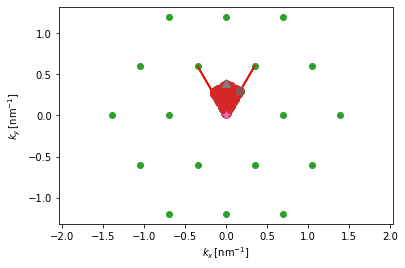

In [3]:
#lenght of reciprocal lattice vectors
G = 8. * np.pi * np.sin(theta / 360. * np.pi)/ (np.sqrt(3) * a)
#define reciprocal lattice basis
#reciprocal_lattice_basis = G * np.array([[          0.5,         -0.5],
#                                         [np.sqrt(3)/2.,np.sqrt(3)/2.]], dtype = float)

#special points
Mxy = int(n_sites/2)
Kxy = int(n_sites/3)

special_points = {'$\Gamma$': (0, 0), '$M$': (Mxy, 0), '$M^\prime$': (0, Mxy), '$K$': (Kxy, Kxy)}

#model = koshino(u0 = uAA, u1 = uAB, theta = theta, hv = hv, a = a, G_max = G_max)
model = koshino(valley = valley, uAA = uAA, uAB = uAB, uAA_nl = uAA_nl, uAB_nl = uAB_nl,
                            theta = theta, hv = hv, a = a, G_max = G_max)

point_group = Point_Group.dihedral_group(n = 3,theta0 = np.arctan2(model['reciprocal_lattice_vectors'].basis_vectors[1,0], 
                                                     model['reciprocal_lattice_vectors'].basis_vectors[0,0]))


lattice_geometry = Crystal_Geometry(reciprocal_lattice_basis = model['reciprocal_lattice_vectors'].basis_vectors, 
                                    point_group = point_group)

k_sample = Unit_Cell_Sample.irreducible_sample(name = '2D_Hexagonal_D3_Axes',
                                               basis_vectors= model['reciprocal_lattice_vectors'].basis_vectors, 
                                               denominator=n_sites)
q_sample = Unit_Cell_Sample.wigner_seitz_cell(basis_vectors= model['reciprocal_lattice_vectors'].basis_vectors, 
                                               denominator=n_sites, special_points=special_points)

#sampling of reciprocal lattice
reciprocal_lattice_vectors = Sample.lattice_sample(basis_vectors=model['reciprocal_lattice_vectors'].basis_vectors, cut_off=G * G_max)

G_sample = Sample.lattice_sample(basis_vectors=model['reciprocal_lattice_vectors'].basis_vectors, cut_off=G * G_cut_off)


k_sample.plot()
G_sample.plot()
plt.xlim(-G * G_max,G * G_max)
plt.ylim(-G * G_max,G * G_max)
reciprocal_lattice_vectors.plot()
k_sample.plot()
#q_sample.plot()
plt.plot(*k_sample.get_coords((0,Mxy)),'o',ms=8)
plt.plot(*k_sample.get_coords((Mxy,0)),'o',ms=8)
plt.plot(*k_sample.get_coords((0,0)),'*',ms=8)
plt.plot(*k_sample.get_coords((Kxy,Kxy)),'^',ms=8)
plt.xlabel(r'$k_x\,[{\rm nm^{-1}}]$')
plt.ylabel(r'$k_y\,[{\rm nm^{-1}}]$')

In [4]:
#Density operator
U = np.kron(pauli_matrix(0),pauli_matrix(0))

matrices=[]
for i in range(len(G_sample)):
    matrices.append(build_potential_term(U=U, i=i, reciprocal_lattice_vectors = reciprocal_lattice_vectors))

coefficients = []
for i in range(len(matrices)):
    coefficients.append(lambda k,q: 1)
    
density_operator = []
for i in range(len(matrices)):
    density_operator.append(Operator(matrices=[matrices[i]], coefficients=[coefficients[i]], collapse=False, hermitian=True))


In [5]:
start = time.time()
####################### Output folder ##################################
output_folder = 'test_output/tblg'
file_name = '/tblg.hdf5'
########################################################################
########################################################################
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
try:
    os.remove(output_folder + file_name)
except:
    pass


band_structure = Band_Structure.from_hamiltonian(k_sample = k_sample, 
                                                 q_sample = q_sample,
                                                 G_sample = G_sample,
                                                 hamiltonian = model['hamiltonian'],
                                                 momentum_operator = model['momentum_operator'],
                                                 density_operator = density_operator,
                                                 degeneracy = 4,
                                                 zero_filling = n_bands,
                                                 density = density,
                                                 temperature = temperature)

band_structure.compute_bands(eigvals = (4 * len(model['reciprocal_lattice_vectors']) // 2 - n_bands,
                        4 * len(model['reciprocal_lattice_vectors']) // 2 + n_bands - 1))
band_structure.compute_momentum_matrix()
band_structure.compute_density_matrix()
band_structure.save(file_name = output_folder + file_name, band_structure_name = 'band_structure')
tblg = Crystal(geometry = lattice_geometry,
                   band_structure=band_structure, eta = eta)

end = time.time()
print(end-start)

100%|██████████| 235/235 [01:22<00:00,  2.86it/s]


91.60068202018738


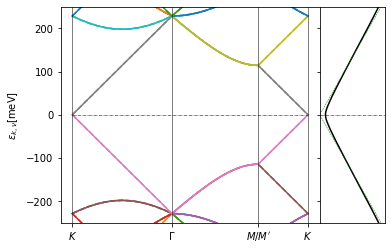

In [6]:
####- BAND PLOT -#####
e_lims = -0.25,0.25 #energy limits for the figure
e_vals = np.linspace(*e_lims,num=250)

contour = tblg.band_structure.k_sample.contour([r'$K$', r'$\Gamma$', r'$M$', r'$K$'])
contour2 = tblg.band_structure.k_sample.contour([r'$K$', r'$\Gamma$', r'$M^\prime$', r'$K$'])
dosvals = tblg.dos(e_vals) #total dos by summing over band-resolved dos
################################################################################
#figure
plt.figure()
plt.axes([0.2,0.2,0.6,0.75])
#band plot
for i in range(2*n_bands):
    p = plt.plot(contour['x'],1e3*tblg.band_structure.energies[i,contour['indices']])
    plt.plot(contour2['x'],1e3*tblg.band_structure.energies[i,contour2['indices']],'--', color = p[0].get_color())
#chemical potential
plt.plot([contour['x'][0],contour['x'][-1]],[tblg.band_structure.chemical_potential,tblg.band_structure.chemical_potential],'-.',c='k', lw=0.5)
#axes and limits
for point in contour['vertices']:
    plt.plot([contour['x'][point],contour['x'][point]],[1e3*e_vals[0],1e3*e_vals[-1]],lw=0.5, c='k')
#plt.plot([np.sqrt(3)/3+0.5,np.sqrt(3)/3+0.5],[1e3*e_vals[0],1e3*e_vals[-1]],lw=0.5, c='k')
plt.ylim(1e3*e_lims[0],1e3*e_lims[-1])
plt.ylabel(r'$\epsilon_{ k,\nu} [\rm meV]$')
plt.xticks(contour['x'][contour['vertices']],[r'$K$', r'$\Gamma$', r'$M/M^\prime$', r'$K$'])

#dos panel
ax = plt.axes([0.8,0.2,0.15,0.75])
ax.yaxis.set_label_position("right")
ax.set_xticks([])
ax.set_yticklabels([])
plt.ylim(1e3*e_lims[0],1e3*e_lims[-1])
plt.xlim(0,1.1*np.amax(dosvals)*1e-3)
plt.plot(1e-3*dosvals ,1e3*e_vals, c='k')
plt.plot(1e-3*abs(e_vals)*4/(np.pi * hv**2),1e3*e_vals,'--', c='g', lw=0.5)
plt.plot([0,1.1*np.amax(dosvals)*1e-3],[tblg.band_structure.chemical_potential,tblg.band_structure.chemical_potential],'-.',c='k', lw=0.5)

plt.savefig(output_folder +'/bands.pdf')

In [7]:
#band_structure_loaded = Band_Structure.from_file(file_name = output_folder + file_name, band_structure_name = 'band_structure')
#tblg = Crystal(geometry = lattice_geometry,
#                   band_structure = band_structure_loaded, 
#                   eta = eta)

In [8]:
#Check number of bands
omega_vals = np.linspace(eta,2.,num=200)

sigma_vals = tblg.local_conductivity(omega_vals)[:,0,0]

../pybandstructure/crystal/analysis/conductivity_functions.py:8: RuntimeWarning: invalid value encountered in true_divide
  prefactor = -occupation_diff / energy_diff


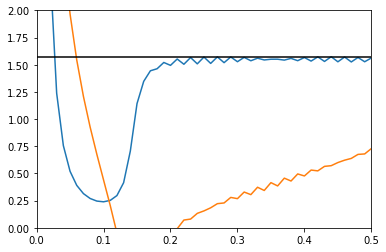

In [9]:
plt.figure(1)
plt.xlim(0.0,0.5)
plt.ylim(0.0,2)
plt.plot(omega_vals,sigma_vals.real)
plt.plot(omega_vals,sigma_vals.imag)
plt.plot([0,2],[0,0],lw=0.5,c='k')
plt.plot([0,2],[np.pi/2,np.pi/2],c='k')


In [10]:
tblg.static_polarization(1,0,0)

../pybandstructure/crystal/analysis/polarization_functions.py:7: RuntimeWarning: invalid value encountered in true_divide
  prefactor = occupation_diff / energy_diff


(-1.5757824951311927+0j)

In [11]:
start = time.time()

chi_vals = []
#Evaluation of the static polarization
for q_ind in range(len(q_sample)):
    chi_vals.append(tblg.static_polarization(q_ind, 0, 0))

chi_vals_arr = np.array(chi_vals)

end = time.time()
print(end-start)

38.25507116317749


In [12]:
plt.figure(1)
plt.axes()
plt.axis('equal')
plt.xlabel(r'$q_x\,[{\rm nm^{-1}}]$')
plt.ylabel(r'$q_y\,[{\rm nm^{-1}}]$')

#valid_index = np.invert(np.isnan(chi_vals_arr[:,0]))

plt.tripcolor(tblg.band_structure.q_sample.coords[:,0], tblg.band_structure.q_sample.coords[:,1],  
            np.real(-chi_vals_arr))

cb = plt.colorbar()
plt.savefig(output_folder +'/chi0real_omega0.pdf')

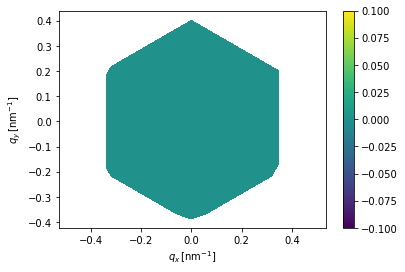

In [13]:
plt.figure(1)
plt.axes()
plt.axis('equal')
plt.xlabel(r'$q_x\,[{\rm nm^{-1}}]$')
plt.ylabel(r'$q_y\,[{\rm nm^{-1}}]$')

#valid_index = np.invert(np.isnan(chi_vals_arr[:,0]))

plt.tripcolor(tblg.band_structure.q_sample.coords[:,0], tblg.band_structure.q_sample.coords[:,1],  
            np.imag(-chi_vals_arr))

cb = plt.colorbar()
plt.savefig(output_folder +'/chi0imag_omega0.pdf')

### Static polarization in Single Layer graphene (Dirac approximation)
$$\Re[\chi_{nn}(q,\omega=0)] = -\frac{1}{16}\frac{|{\bf q}|}{v}$$
 This quantity is for unit spin and valley.

In [14]:
chi_exact = []
if uAA == 0.:
    for q_ind in range(len(q_sample)):
        chi_exact.append(gr.chi(omega = 0.,
               q = lin.norm(tblg.band_structure.q_sample.get_coords(q_ind)),
               Ef = tblg.band_structure.chemical_potential))
chi_exact_arr = np.array(chi_exact)

/Users/Cavo/bandstructure-calculation/notebooks/graphene.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  Dplus  = (omega/hv_F + 2.*k_F)/q
/Users/Cavo/bandstructure-calculation/notebooks/graphene.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  Dminus = (omega/hv_F - 2.*k_F)/q
/Users/Cavo/bandstructure-calculation/notebooks/graphene.py:61: RuntimeWarning: divide by zero encountered in double_scalars
  it1 = 8.*k_F/(hv_F*q*q)
/Users/Cavo/bandstructure-calculation/notebooks/graphene.py:52: RuntimeWarning: invalid value encountered in cdouble_scalars
  sz2m1 = np.sqrt(z-1.)*np.sqrt(z+1.)
/Users/Cavo/bandstructure-calculation/notebooks/graphene.py:53: RuntimeWarning: invalid value encountered in cdouble_scalars
  return z*sz2m1 - np.log(z + sz2m1)


In [18]:
###Plotting -chi_nn (q,omega=0,0,0)/N(0)
contour = [r'$\Gamma$', r'$K$']
plotting_contour = tblg.band_structure.q_sample.contour(contour)
index = plotting_contour["indices"]
distances = plotting_contour["x"]
points = plotting_contour["vertices"]

plt.plot(distances, -chi_vals_arr[index].real, label='chi_vals')
plt.plot(distances, -2*chi_exact_arr[index].real, label='chi_exact')
#plt.plot(distances, -1/4*(distances/hv), label='chi_analitic')
chi_min = 1.1 * np.amin(-chi_vals_arr[index]) - 0.1 * np.amax(-chi_vals_arr[index])
chi_max = 1.1 * np.amax(-chi_vals_arr[index]) - 0.1 *np.amin(-chi_vals_arr[index])

frame = []
for point in points:
    frame.append(
        plt.plot(
            [distances[point], distances[point]],
            [chi_min, chi_max],
            lw=0.5,
            c="k",
                )
        )
plt.xticks(distances[points], contour)
#plt.ylim(0.,0.5)
plt.legend()
plt.savefig(output_folder +'/chi0real_omega0.pdf')

/Users/Cavo/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
